<h1><center>Accessing Swarm data and models with VirES - first usage</center></h1>

VirES is a platform for data & model access, analysis, and visualisation for ESA's magnetic mission, *Swarm*

This tutorial introduces the Python interface to VirES, `viresclient`. This notebook demonstrates usage of the primary Swarm magnetic dataset (`SW_OPER_MAGA_LR_1B`) and geomagnetic field models produced as part of the Swarm mission. Some knowledge of `pandas` and `matplotlib` is assumed.

For more information see:
- https://vires.services/ (Web interface)
- https://viresclient.readthedocs.io (Python interface)
- https://earth.esa.int/web/guest/missions/esa-eo-missions/swarm/mission-overview

In [1]:
%%HTML
<iframe width="840" height="472" src="https://www.youtube.com/embed/L25IvTwgjG4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## 0. Configuration

To access VirES through Python code, you first need to generate an *access token* from your VirES account:

1. Create a user account at https://vires.services/ if you haven't already done so
2. Login there and go to settings (top right: the button with your user name)
3. Select "Manage access tokens" and follow the instructions to create a token (see first part of video above)
4. Copy the token into the box which will appear when you run the code below
5. The default has now been configured and you won't need to provide the token again.

This can also be done via the command line. For more info, see https://viresclient.readthedocs.io/en/latest/installation.html#first-usage-configuration

### Enter your access token

Run this code and you will be prompted to enter the access token. The token and site url are stored in a configuration file at `~.viresclient,ini`. You may generate and set a new token, or revoke old tokens, at any point.

NB: You will need to repeat this procedure if you are running viresclient from different machines / user spaces.

In [2]:
from viresclient import set_token

set_token("https://vires.services/ows")
# (user is now prompted to enter the token)

Enter access token: ································


## 1. Fetching some data

Import the `SwarmRequest` object which provides the VirES interface, and `datetime` which gives convenient time objects which can be used by `SwarmRequest.get_between()`

In [3]:
from viresclient import SwarmRequest
import datetime as dt
%matplotlib inline

The following code will fetch one day (i.e. around 15 orbits) of the scalar (`F`) measurements from Swarm Alpha. `sampling_step="PT10S"` downsamples the data to 10 seconds, from the `MAGx_LR` default of 1 second - strings to choose the `sampling_step` should be provided as [ISO 8601 durations](https://en.wikipedia.org/wiki/ISO_8601#Durations) (e.g. `"PT1M"` for 1-minute sampling).

Several keyword arguments can be provided to `.set_products()` to specify the type of data you want. The `measurements` available depend on the collection chosen in `.set_collection()`. The same set of `auxiliaries` are available for all collections - here we also choose to fetch the `MLT` - magnetic local time.

`start_time` and `end_time` in `.get_between()` together provide the time window you want to fetch data for - executing this line causes the request to be processed on the server and the data returned to you.

In [4]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=["F"],
    sampling_step="PT10S",
    auxiliaries=["MLT"]
)

data = request.get_between(
    start_time=dt.datetime(2016,1,1),
    end_time=dt.datetime(2016,1,2)
)

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.428MB)


The data is now contained within the object which we called `data`:

In [5]:
data

It is actually a wrapper around a temporary CDF file which could be written to disk directly:

In [6]:
data.to_file("test_file.cdf", overwrite=True)

Data written to test_file.cdf


... but it is possible to directly transfer it to a `pandas` `DataFrame` object:

In [7]:
df = data.as_dataframe()
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Spacecraft,Latitude,Longitude,Radius,F,MLT
2016-01-01 00:00:00,A,-72.499224,92.793967,6833853.08,46935.8083,1.727234
2016-01-01 00:00:10,A,-73.130685,93.091639,6833864.74,46908.3246,1.500887
2016-01-01 00:00:20,A,-73.761537,93.414902,6833875.98,46878.3804,1.257536
2016-01-01 00:00:30,A,-74.391708,93.766833,6833886.81,46846.0555,0.997229
2016-01-01 00:00:40,A,-75.021114,94.151014,6833897.24,46811.5549,0.720646


Try plotting some things to visualise the data. The following shows the variation in field strength measured by the satellite as it passes between high and low latitudes, varying from one orbit to the next as it samples a different longitude.

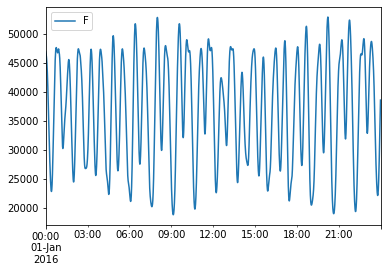

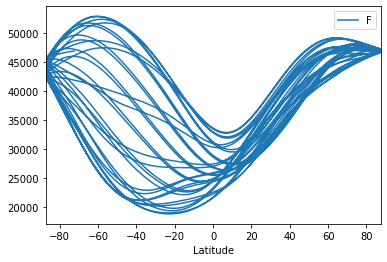

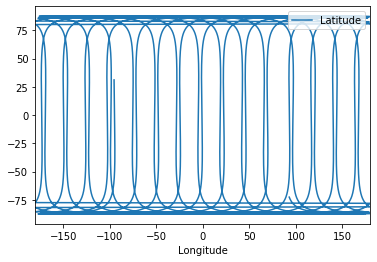

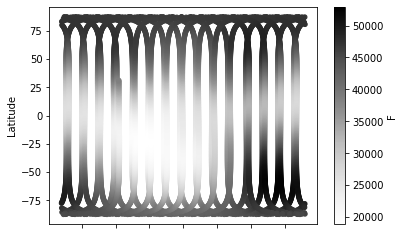

In [8]:
df.plot(y="F")
df.plot(y="F", x="Latitude")
df.plot(y="Latitude", x="Longitude")
df.plot(y="Latitude", x="Longitude", c="F", kind="scatter");

## 2. Fetching model evaluations at the same time

Various (mostly spherical harmonic) models of the magnetic field are produced as Swarm mission products and these are available through VirES. They are evaluated on demand at the same points and times as the data sample points. Here we ask for the `MCO_SHA_2D` model, a dedicated core field model produced from Swarm data. By supplying `residuals=True` we will get the data-model residuals, named in the dataframe as `F_res_MCO_SHA_2D`.

In [9]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=["F"],
    models=["MCO_SHA_2D"],
    residuals=True,
    sampling_step="PT10S"
)

data = request.get_between(
    start_time=dt.datetime(2016,1,1),
    end_time=dt.datetime(2016,1,2)
)

df = data.as_dataframe()
df.head()

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.359MB)


,Spacecraft,Latitude,Longitude,Radius,F_res_MCO_SHA_2D
2016-01-01 00:00:00,A,-72.499224,92.793967,6833853.08,111.980426
2016-01-01 00:00:10,A,-73.130685,93.091639,6833864.74,108.278648
2016-01-01 00:00:20,A,-73.761537,93.414902,6833875.98,104.358770
2016-01-01 00:00:30,A,-74.391708,93.766833,6833886.81,100.296102
2016-01-01 00:00:40,A,-75.021114,94.151014,6833897.24,96.294332


The core field has been removed from the data so the amplitudes are much smaller. Can you interprete the new signals in terms of external fields, i.e. from the ionosphere and magnetosphere?

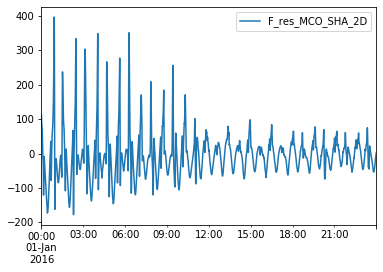

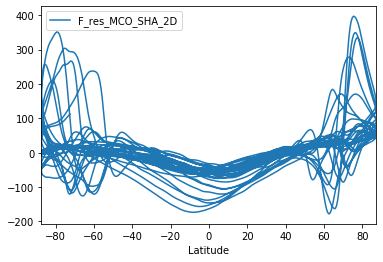

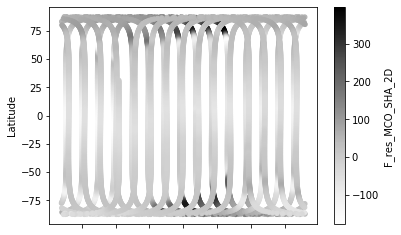

In [10]:
df.plot(y="F_res_MCO_SHA_2D")
df.plot(y="F_res_MCO_SHA_2D", x="Latitude")
df.plot(y="Latitude", x="Longitude", c="F_res_MCO_SHA_2D", kind="scatter");

## 3. More complex model handling

We can also remove a magnetospheric field model at the same time, by specifying a new model (which I call `MCO_MMA` here, but can be named whatever you like) which is the sum of core and magnetospheric models. See `model_residuals_and_cartopy.ipynb` for more examples of this - it is also possible to specify the spherical harmonic degrees (min/max) to use, and to provide your own `.shc` model.

The remaining signal is now primarily due to the ionosphere.

Note that here I am instead using the CI (comprehensive inversion) core and magnetosphere models (`2C`).

In [11]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=["F"],
    models=["MCO_MMA = 'MCO_SHA_2C' + 'MMA_SHA_2C-Primary' + 'MMA_SHA_2C-Secondary'"],
    residuals=True,
    sampling_step="PT10S",
    auxiliaries=["MLT"]
)

data = request.get_between(
    start_time=dt.datetime(2016,1,1),
    end_time=dt.datetime(2016,1,2)
)

df = data.as_dataframe()
df.head()

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.429MB)


,Spacecraft,Latitude,Longitude,Radius,F_res_MCO_MMA,MLT
2016-01-01 00:00:00,A,-72.499224,92.793967,6833853.08,81.105345,1.727234
2016-01-01 00:00:10,A,-73.130685,93.091639,6833864.74,76.994628,1.500887
2016-01-01 00:00:20,A,-73.761537,93.414902,6833875.98,72.672585,1.257536
2016-01-01 00:00:30,A,-74.391708,93.766833,6833886.81,68.209912,0.997229
2016-01-01 00:00:40,A,-75.021114,94.151014,6833897.24,63.805549,0.720646


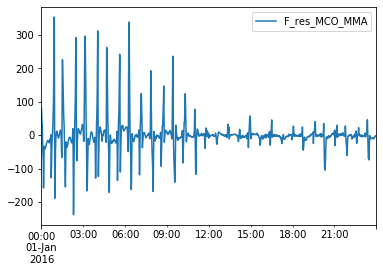

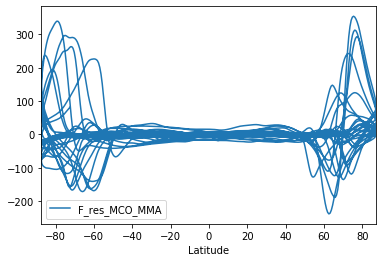

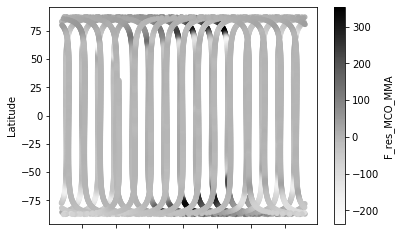

In [12]:
df.plot(y="F_res_MCO_MMA")
df.plot(y="F_res_MCO_MMA", x="Latitude")
df.plot(y="Latitude", x="Longitude", c="F_res_MCO_MMA", kind="scatter");

## 4. Explore the other possibilites through VirES

To find out what other data and models are available, see https://viresclient.readthedocs.io/en/latest/available_parameters.html

For examples see https://github.com/smithara/viresclient_examples